In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import RandomOverSampler
sns.set(style='whitegrid')

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("data.csv")
df.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


In [3]:
df = df.dropna()

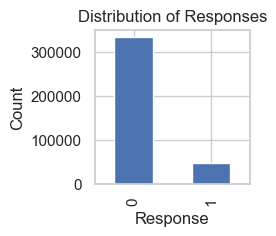

In [4]:
value_counts = df['Response'].value_counts()

plt.figure(figsize=(2, 2))

# Create the bar plot
value_counts.plot(kind='bar')

# Customize the plot (optional)
plt.xlabel('Response')
plt.ylabel('Count')
plt.title('Distribution of Responses')

# Show the plot
plt.show()

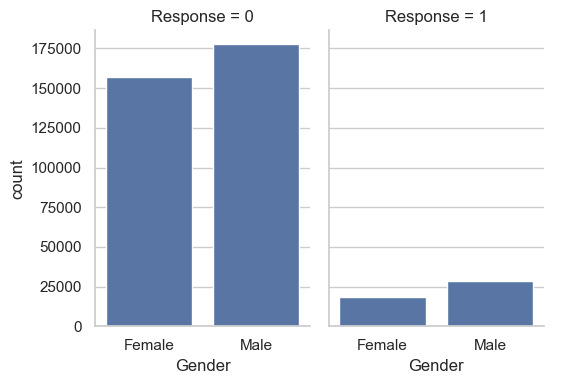

In [5]:
data = df.groupby(['Gender','Response'])['id'].count().to_frame().rename(columns={'id':'count'}).reset_index()

g = sns.catplot(x="Gender", y="count",col="Response", data=data, kind="bar", height=4, aspect=.7);

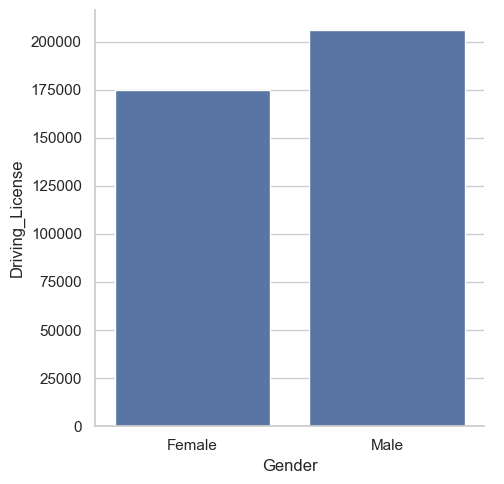

In [6]:
# driving license by gender

data=df.groupby(['Gender'])['Driving_License'].count().to_frame().reset_index()
sns.catplot(x="Gender", y="Driving_License", data=data, kind="bar");

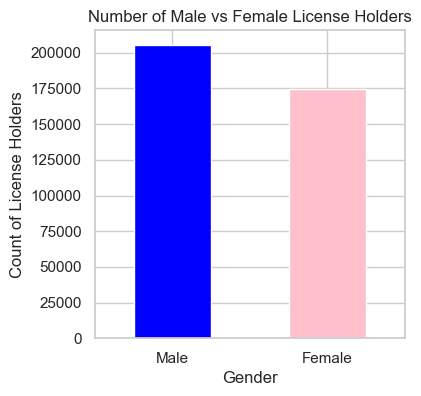

In [7]:
# Filter for only license holders (Driving_License == 1)
license_holders = df[df['Driving_License'] == 1]

# Group by Gender and count the number of license holders per gender
gender_counts = license_holders['Gender'].value_counts()

# Plotting
plt.figure(figsize=(4, 4))
gender_counts.plot(kind='bar', color=['blue', 'pink'])
plt.title('Number of Male vs Female License Holders')
plt.xlabel('Gender')
plt.ylabel('Count of License Holders')
plt.xticks(rotation=0)
plt.show()


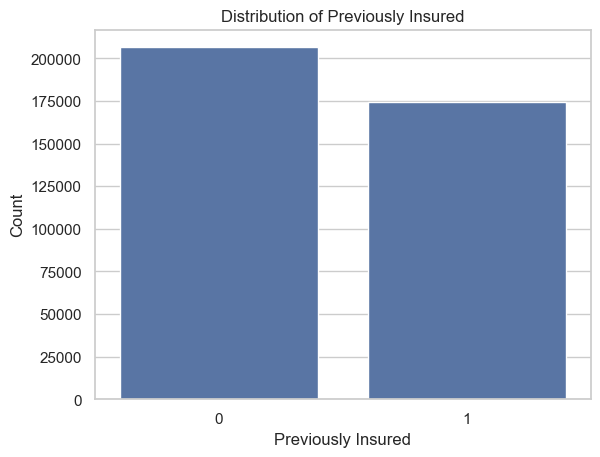

In [8]:
# customers with existing insurance

sns.countplot(x="Previously_Insured", data=df)
plt.title("Distribution of Previously Insured")
plt.xlabel("Previously Insured")
plt.ylabel("Count")
plt.show()

In [9]:
# Response vs Vehicle_Age

data=df.groupby(['Vehicle_Age','Response'])['id'].count().to_frame().rename(columns={'id':'count'}).reset_index()
data

,Vehicle_Age,Response,count
0,1-2 Year,0,165510
1,1-2 Year,1,34806
2,< 1 Year,0,157584
3,< 1 Year,1,7202
4,> 2 Years,0,11305
5,> 2 Years,1,4702


In [10]:
num_feat = ['Age','Vintage']
cat_feat = ['Gender', 'Driving_License', 'Previously_Insured', 'Vehicle_Age_lt_1_Year',
'Vehicle_Age_gt_2_Years','Vehicle_Damage_Yes','Region_Code','Policy_Sales_Channel']

In [11]:
# mapping 'Gender' col to (0, 1) values
df['Gender'] = df['Gender'].map( {'Female': 0, 'Male': 1} ).astype(int)
df.head(2)

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,1,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,1,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0


In [12]:
for col in df.columns:
    print(f"{col} >> {df[col].dtype}")

id >> int64
Gender >> int64
Age >> int64
Driving_License >> int64
Region_Code >> float64
Previously_Insured >> int64
Vehicle_Age >> object
Vehicle_Damage >> object
Annual_Premium >> float64
Policy_Sales_Channel >> float64
Vintage >> int64
Response >> int64


In [13]:
# creating dummy cols for categorical features

df=pd.get_dummies(df,drop_first=True)
df.head(2)

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Vintage,Response,Vehicle_Age_< 1 Year,Vehicle_Age_> 2 Years,Vehicle_Damage_Yes
0,1,1,44,1,28.0,0,40454.0,26.0,217,1,False,True,True
1,2,1,76,1,3.0,0,33536.0,26.0,183,0,False,False,False


In [14]:
# cols renaming and keeping dtype as int

df = df.rename(columns={"Vehicle_Age_< 1 Year": "Vehicle_Age_lt_1_Year", "Vehicle_Age_> 2 Years": "Vehicle_Age_gt_2_Years"})
df['Vehicle_Age_lt_1_Year'] = df['Vehicle_Age_lt_1_Year'].astype('int')
df['Vehicle_Age_gt_2_Years'] = df['Vehicle_Age_gt_2_Years'].astype('int')
df['Vehicle_Damage_Yes'] = df['Vehicle_Damage_Yes'].astype('int')

for column in cat_feat:
    df[column] = df[column].astype('str')

In [15]:
# scaling the data

from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, RobustScaler

ss = StandardScaler()
df[num_feat] = ss.fit_transform(df[num_feat])


mm = MinMaxScaler()
df[['Annual_Premium']] = mm.fit_transform(df[['Annual_Premium']])

# also, dropping id col now
id=df.id
df=df.drop('id',axis=1)

In [16]:
# train-test split

from sklearn.model_selection import train_test_split

train_target=df['Response']
train=df.drop(['Response'], axis = 1)
x_train,x_test,y_train,y_test = train_test_split(train,train_target, random_state = 0)

In [17]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

random_search = {'criterion': ['entropy', 'gini'],
               'max_depth': [2,3,4,5,6,7,10],
               'min_samples_leaf': [4, 6, 8],
               'min_samples_split': [5, 7,10],
               'n_estimators': [50]}

clf = RandomForestClassifier()
model = RandomizedSearchCV(estimator = clf, param_distributions = random_search, n_iter = 10, 
                               cv = 4, verbose= 1, random_state= 101, n_jobs = -1)
model.fit(x_train,y_train)

Fitting 4 folds for each of 10 candidates, totalling 40 fits


RandomizedSearchCV(cv=4, estimator=RandomForestClassifier(), n_jobs=-1,
                   param_distributions={'criterion': ['entropy', 'gini'],
                                        'max_depth': [2, 3, 4, 5, 6, 7, 10],
                                        'min_samples_leaf': [4, 6, 8],
                                        'min_samples_split': [5, 7, 10],
                                        'n_estimators': [300]},
                   random_state=101, verbose=1)

In [18]:
# save model

import pickle

filename = 'rf_model.pkl'
pickle.dump(model, open(filename, 'wb'))

In [19]:
# loading back pickle file

rf_load = pickle.load(open(filename, 'rb'))